In [7]:
# Load the Pandas library to read experimental data from the Marionette paper [1]
import pandas as pd
# Import pacti PolyhedralContract class to read contracts
from pacti.contracts import PolyhedralIoContract
from pacti.terms.polyhedra.polyhedra import PolyhedralTerm
from pacti.iocontract.iocontract import Var
from synbio_functions import create_sensor_contracts
from load_data import load_data
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Import Python numpy
import numpy as np
import re

# Read the data from the paper using the CSV file "marionette_data.csv"
df = pd.read_csv("data/marionette_data_with_std.csv", delimiter=",", engine="python")

# Add the new "std" column with random values between 0.1 and 0.3

df['std'] = np.random.uniform(0.7, 0.71, len(df))

# Write the updated DataFrame to a new CSV file
df.to_csv('data/marionette_data_with_std.csv', index=False)
# Load Eric data
all_absolute_data = load_data("absolute")
all_normalized_data = load_data("normalized")
# Create all sensor contracts:
sensor_names = [str(i) for i in df["Inducer"]]
sensor_library = {}
sensor_library_params = {}
for sensor in sensor_names:
    sensor_params = {}
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]
    yleak_s = yleak_s * 1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    ymax_sat = df.loc[df["Inducer"] == sensor]["ymax (RPU)"].values[0]
    std = df.loc[df["Inducer"] == sensor]["std"].values[0]
    sexp_start = s_start
    sexp_K = 100*s_K
    if sensor in all_normalized_data:
        curr_data = all_normalized_data[sensor]
        # Extract numerical part from column names and convert them to integers
        column_numbers = [float(re.match(r'(\d+\.?\d*)', col).group()) for col in curr_data.columns if re.match(r'(\d+\.?\d*)', col)]
        sorted_column_numbers = sorted(column_numbers)
        sexp_K = max(column_numbers)
        sexp_start = min(column_numbers)
        sexp_start = sorted_column_numbers[1]
        s_K = sorted_column_numbers[2]
    # if sensor == "Sal":
    #     s_start = 25*s_start
    #     K = 8*s_K
#         sexp_K = 40*s_K
    if sensor == "aTc":
        s_start = 4*s_start
        sexp_K = 100*s_K
        s_K = s_K
    if sensor == "OHC14":
        s_K = s_K
    sensor_params = {"leak": yleak_s, "start": s_start,
                     "K": s_K, "ymax": ymax_s, "std":std, "ymax_sat":ymax_sat, 
                     "exp_start":sexp_start, "exp_K":sexp_K}
    s_output = "dCas9"
    contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(
        sensor_input=sensor, output="xRFP", start=s_start, K=s_K,
        ymax_lin=ymax_s, yleak=yleak_s, std=std, ymax_sat = ymax_sat, final_K = sexp_K,
    )
    sensor_library[sensor] = [contract_s_0, contract_s_lin, contract_s_max]
    sensor_library_params[sensor] = sensor_params

# Create available sensor contracts:
sensor_contracts = {}

contract_DAPG_off, contract_DAPG_lin, contract_DAPG_sat = create_sensor_contracts(
    sensor_input="DAPG", output="xRFP", start=sensor_library_params["DAPG"]["start"],
    K=sensor_library_params["DAPG"]["K"],
    ymax_lin=sensor_library_params["DAPG"]["ymax"], yleak=sensor_library_params["DAPG"]["leak"],
    ymax_sat=sensor_library_params["DAPG"]["ymax_sat"],
    std=sensor_library_params["DAPG"]["std"], final_K = sensor_library_params["DAPG"]["exp_K"],
)
#sensor_contracts["DAPG"] = [contract_DAPG_off, contract_DAPG_lin, contract_DAPG_sat]
sensor_contracts["DAPG"] = [contract_DAPG_off, contract_DAPG_sat]


contract_Van_off, contract_Van_lin, contract_Van_sat = create_sensor_contracts(
    sensor_input="Van", output="xRFP", start=sensor_library_params["Van"]["start"],
    K=sensor_library_params["Van"]["K"],
    ymax_lin=sensor_library_params["Van"]["ymax"], yleak=sensor_library_params["Van"]["leak"],
    ymax_sat=sensor_library_params["Van"]["ymax_sat"],
    std=sensor_library_params["Van"]["std"], final_K = sensor_library_params["Van"]["exp_K"],
)
sensor_contracts["Van"] = [contract_Van_off, contract_Van_sat]


contract_OC6_off, contract_OC6_lin, contract_OC6_sat = create_sensor_contracts(
    sensor_input="OC6", output="xRFP", start=sensor_library_params["OC6"]["start"],
    K=sensor_library_params["OC6"]["K"],
    ymax_lin=sensor_library_params["OC6"]["ymax"], yleak=sensor_library_params["OC6"]["leak"],
    ymax_sat=sensor_library_params["OC6"]["ymax_sat"],
    std=sensor_library_params["OC6"]["std"], final_K = sensor_library_params["OC6"]["exp_K"],
)
sensor_contracts["OC6"] = [contract_OC6_off, contract_OC6_sat]


def reflect(low_high_contract : list[PolyhedralIoContract], newoutput_name) -> list[PolyhedralIoContract]:
    from pacti.terms.polyhedra import PolyhedralTerm, PolyhedralTermList
    # standard off and on thresholds
    std_off_threshold = 1
    std_on_threshold = 10
    # the upper bound of the off region
    invar = low_high_contract[0].inputvars[0]
    outvar = low_high_contract[0].outputvars[0]
    newoutvar = Var(newoutput_name)
    x_off_u = low_high_contract[0].get_variable_bounds(str(invar))[1]
    # the lower bound of the high region
    x_on_l = low_high_contract[1].get_variable_bounds(str(invar))[0]
    # new upper guarantees
    new_guarantees = []
    term : PolyhedralTerm
    for term in low_high_contract[1].g.terms:
        y_val = (term.constant - term.get_coefficient(invar)*x_on_l)/term.get_coefficient(outvar)
        new_term = PolyhedralTerm(
            variables={invar:term.get_coefficient(invar), newoutvar:term.get_coefficient(outvar)},
            constant=term.get_coefficient(invar) * std_on_threshold + term.get_coefficient(outvar) * y_val 
            )
        new_guarantees.append(new_term)
    upper_contract = PolyhedralIoContract(
        input_vars=[invar],
        output_vars=[newoutvar],
        assumptions=PolyhedralTermList(
            [
                #PolyhedralTerm(variables={invar:1}, constant=4*std_on_threshold),
                PolyhedralTerm(variables={invar:-1}, constant=-1*std_on_threshold),
        ]),
        guarantees=PolyhedralTermList(new_guarantees)).rename_variable(invar,Var('universal'))
    # now get the new lower contract
    new_guarantees = []
    term : PolyhedralTerm
    for term in low_high_contract[0].g.terms:
        y_val = (term.constant - term.get_coefficient(invar)*x_off_u)/term.get_coefficient(outvar)
        new_term = PolyhedralTerm(
            variables={invar:term.get_coefficient(invar), newoutvar:term.get_coefficient(outvar)},
            constant=term.get_coefficient(invar) * std_off_threshold + term.get_coefficient(outvar) * y_val 
            )
        new_guarantees.append(new_term)
    lower_contract = PolyhedralIoContract(
        input_vars=[invar],
        output_vars=[newoutvar],
        assumptions=PolyhedralTermList(
            [
                PolyhedralTerm(variables={invar:1}, constant=std_off_threshold),
                PolyhedralTerm(variables={invar:-1}, constant=-0.1*std_off_threshold),
        ]),
        guarantees=PolyhedralTermList(new_guarantees)).rename_variable(invar,Var('universal'))
    
    return [lower_contract, upper_contract]
    

lux_contracts = reflect(sensor_contracts['OC6'],"GFP")
vancc_contracts = reflect(sensor_contracts['Van'],"GFP")
PhiF_contracts = reflect(sensor_contracts['DAPG'],"GFP")
        



In [8]:
lux_contracts[0]

<Var InVars: [universal]
OutVars:[GFP]
A: [
  universal <= 1
  -universal <= -0.1
]
G: [
  GFP - 2.002 universal <= -1.998
  -GFP + 0.3454 universal <= 0.3446
]>

InVars: [OC6]
OutVars:[xRFP]
A: [
  -OC6 <= -2
  OC6 <= 20
]
G: [
  -0.07581 OC6 + xRFP <= 0.7013
  0.01308 OC6 - xRFP <= -0.121
]


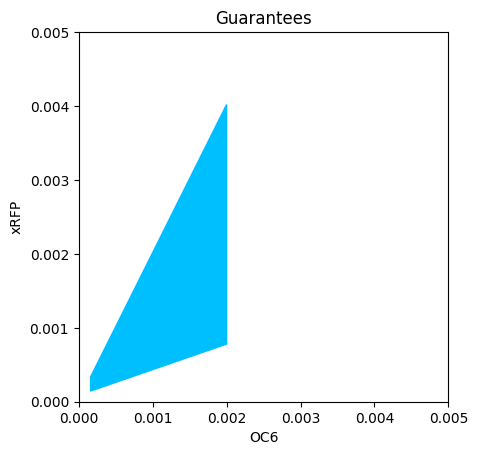

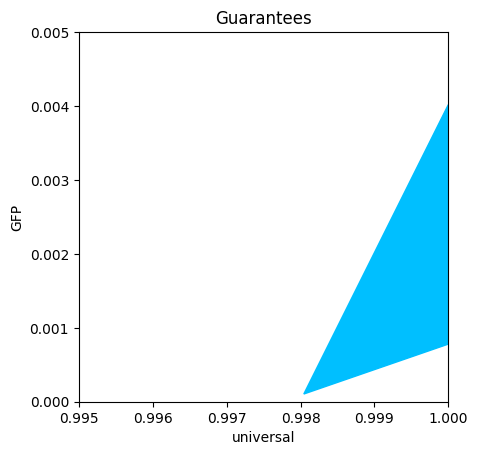

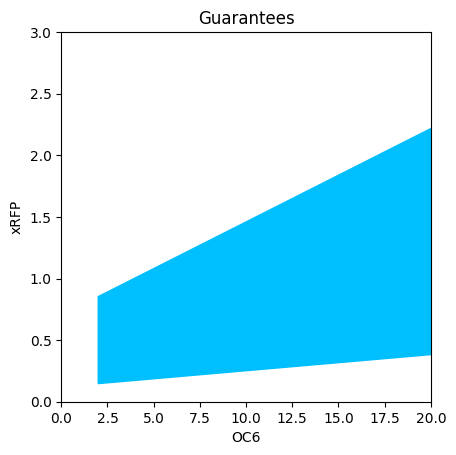

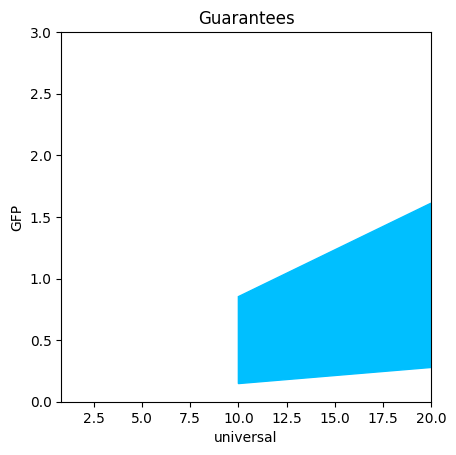

In [9]:
from pacti.utils.plots import plot_guarantees

oc6_low : PolyhedralIoContract = sensor_contracts['OC6'][0]
oc6_high : PolyhedralIoContract = sensor_contracts['OC6'][1]
print(oc6_high)
ivar= oc6_low.inputvars[0]
newinput = Var("universal")

_=plot_guarantees(contract=oc6_low,
                x_var=ivar,
                y_var=oc6_low.outputvars[0],
                var_values={},
                x_lims=(0,0.005),
                y_lims=(0,0.005))

_=plot_guarantees(contract=lux_contracts[0],
                x_var=newinput,
                y_var=lux_contracts[0].outputvars[0],
                var_values={},
                x_lims=(0.995,1),
                y_lims=(0,0.005))

_=plot_guarantees(contract=oc6_high,
                x_var=ivar,
                y_var=oc6_high.outputvars[0],
                var_values={},
                x_lims=(0,20),
                y_lims=(0,3))


_=plot_guarantees(contract=lux_contracts[1],
                x_var=newinput,
                y_var=lux_contracts[1].outputvars[0],
                var_values={},
                x_lims=(0.8,20),
                y_lims=(0,3))







In [10]:
# The following dataframe contains the experimental data on LuxB.
# By observing the table, we will consider ON any value of the protein larger than 2000 and OFF any value smaller than 1000
df = pd.read_csv('Dat_for_Ayush/LuxB_complex.csv')
df

,Drug/Concentration,0,2.5,5,10,20
0,0,697.760717,769.927774,835.904437,966.872006,877.900194
1,125,692.642354,750.232249,868.203390,905.657805,2438.801906
2,250,757.750163,841.529334,855.056932,1104.458599,2540.771930
3,500,736.955148,798.810311,883.592167,1001.121233,2961.609033
4,1000,726.638089,767.699407,854.840894,2589.372694,3151.884853
5,2000,835.535600,842.154882,1180.152672,3010.233258,3611.780636


In [11]:
from scipy.optimize import curve_fit


xVals = df["Drug/Concentration"]
keys = ['0','2.5','5','10','20']


key = keys[-2]


col = df[key]
x_local = xVals[col > 2000]
######################################
######################################
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ARBITRARY DIVISION BY 1000
col = col[col > 2000] / 1000

# new top-level output name: GFP 

params, _ = curve_fit(lambda x, m, b: m*x + b, x_local.to_numpy(), col.to_numpy())
system_contract_h = PolyhedralIoContract.from_strings(
    input_vars = ["IPTG"],
    output_vars = ["GFP"],
    assumptions=[f"IPTG >= {x_local.to_numpy()[0]}"],
    guarantees = [
        f"GFP <= {params[0]} * IPTG + {params[1]} + 1.9",
        f"GFP >= {params[0]} * IPTG + {params[1]} - 1.9"
    ]
)

missing_h = system_contract_h.quotient(lux_contracts[1])


c:\Users\iir\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


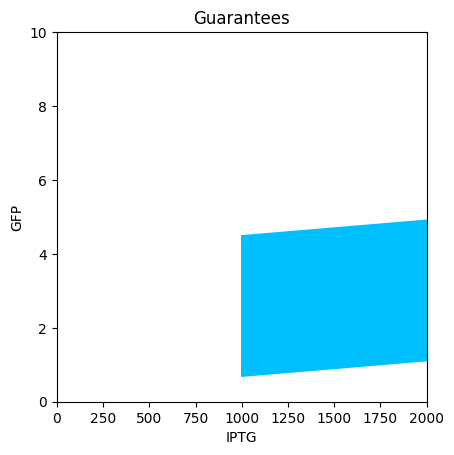

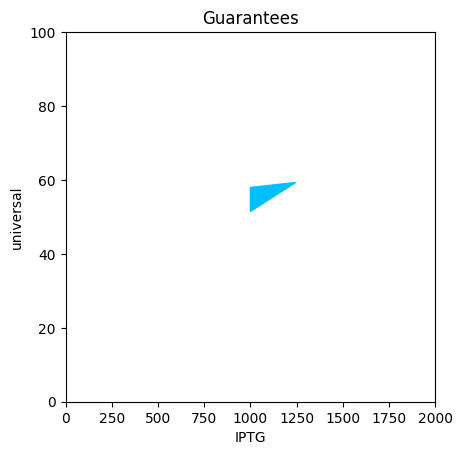

In [12]:
_=plot_guarantees(contract=system_contract_h,
                x_var=system_contract_h.inputvars[0],
                y_var=system_contract_h.outputvars[0],
                var_values={},
                x_lims=(0,2000),
                y_lims=(0,10))

_=plot_guarantees(contract=missing_h,
                x_var=missing_h.inputvars[0],
                y_var=missing_h.outputvars[0],
                var_values={},
                x_lims=(0,2000),
                y_lims=(0,100))

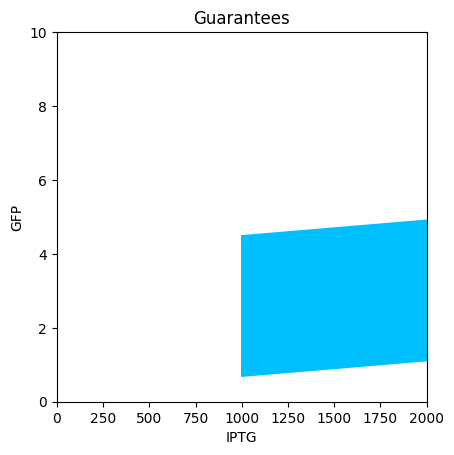

In [13]:
lux_system_h = missing_h.compose(lux_contracts[1])
vancc_system_h = missing_h.compose(vancc_contracts[1])
phif_system_h = missing_h.compose(PhiF_contracts[1])

_=plot_guarantees(contract=lux_system_h,
                x_var=lux_system_h.inputvars[0],
                y_var=lux_system_h.outputvars[0],
                var_values={},
                x_lims=(0,2000),
                y_lims=(0,10))

In [14]:
# now we carry the same analysis for the lower range 
xVals = df["Drug/Concentration"]
keys = ['0','2.5','5','10','20']


key = keys[-2]


col = df[key]
x_local = xVals[col < 1000]
######################################
######################################
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ARBITRARY DIVISION BY 1000
col = col[col < 1000] / 1000

# new top-level output name: GFP 

params, _ = curve_fit(lambda x, m, b: m*x + b, x_local.to_numpy(), col.to_numpy())
system_contract_l = PolyhedralIoContract.from_strings(
    input_vars = ["IPTG"],
    output_vars = ["GFP"],
    assumptions=[f"IPTG <= {x_local.to_numpy()[-1]}"],
    guarantees = [
        f"GFP <= {params[0]} * IPTG + {params[1]} + 1.9",
        f"GFP >= {params[0]} * IPTG + {params[1]} - 1.9"
    ]
)

missing_l = system_contract_l.quotient(lux_contracts[0])


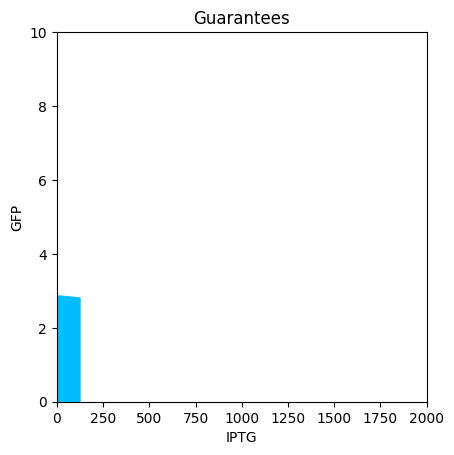

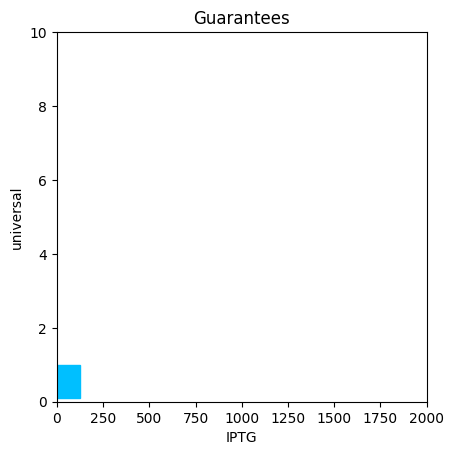

In [15]:
_=plot_guarantees(contract=system_contract_l,
                x_var=system_contract_l.inputvars[0],
                y_var=system_contract_l.outputvars[0],
                var_values={},
                x_lims=(0,2000),
                y_lims=(0,10))

_=plot_guarantees(contract=missing_l,
                x_var=missing_l.inputvars[0],
                y_var=missing_l.outputvars[0],
                var_values={},
                x_lims=(0,2000),
                y_lims=(0,10))

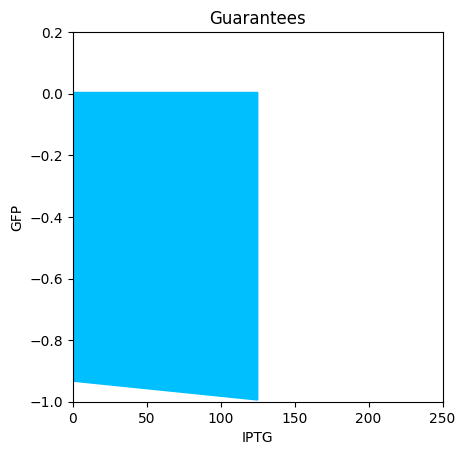

In [16]:
lux_system_l =   missing_l.compose(lux_contracts[0])
vancc_system_l = missing_l.compose(vancc_contracts[0])
phif_system_l =  missing_l.compose(PhiF_contracts[0])

_=plot_guarantees(contract=lux_system_l,
                x_var=lux_system_l.inputvars[0],
                y_var=lux_system_l.outputvars[0],
                var_values={},
                x_lims=(0,250),
                y_lims=(-1,0.2))

In [17]:
# predict fold changes

threshold_h = -lux_system_h.a.terms[0].constant
threshold_l = lux_system_l.a.terms[0].constant

def evaluateGuarantees(contract, value):
    term : PolyhedralTerm
    vals = []
    for term in contract.g.terms:
        nt : PolyhedralTerm = term.substitute_variable(contract.inputvars[0], PolyhedralTerm(variables={},constant=-value))
        val = nt.isolate_variable(contract.outputvars[0]).constant
        vals.append(val)
    vals.sort()
    return vals


lux_h_vals = evaluateGuarantees(lux_system_h,threshold_h)
lux_l_vals = evaluateGuarantees(lux_system_l,threshold_l)
print(lux_h_vals)
print(lux_l_vals)

print(f"LuxR fold change: {lux_h_vals[0]/lux_l_vals[1]}")

vancc_h_vals = evaluateGuarantees(vancc_system_h,threshold_h)
vancc_l_vals = evaluateGuarantees(vancc_system_l,threshold_l)
print(vancc_h_vals)
print(vancc_l_vals)

print(f"Vancc fold change: {vancc_h_vals[0]/vancc_l_vals[1]}")


phif_h_vals = evaluateGuarantees(phif_system_h,threshold_h)
phif_l_vals = evaluateGuarantees(phif_system_l,threshold_l)
print(phif_h_vals)
print(phif_l_vals)

print(f"PhiF fold change: {phif_h_vals[0]/phif_l_vals[1]}")

[0.6893726940000002, 4.489372693999998]
[-0.9943421949999999, 0.004020228015500224]
LuxR fold change: 171.47601860941307
[0.5299813441002426, 3.113860475525124]
[-0.0011974518377959077, 0.00015754271248896617, 0.004026916459145498]
Vancc fold change: 3364.0486172114174
[0.6275478698596783, 3.651754002934508]
[-0.06860688146622712, 0.004184513430818983]
PhiF fold change: 149.96913744804402


In [18]:

files = ['Dat_for_Ayush/LuxB_complex.csv','Dat_for_Ayush/VanCC_complex.csv','Dat_for_Ayush/PhiF_complex.csv']
for file in files: 
    df = pd.read_csv(file)
    xVals = df["Drug/Concentration"]
    keys = ['0','2.5','5','10','20']


    key = keys[-2]


    col = df[key]
    print(col)



0     966.872006
1     905.657805
2    1104.458599
3    1001.121233
4    2589.372694
5    3010.233258
Name: 10, dtype: float64
0    11781.23315
1    17432.83331
2    16576.79539
3    15833.30436
4    15565.39061
5    15829.57091
Name: 10, dtype: float64
0    22942.93629
1    26017.31758
2    23920.93537
3    26818.00418
4    26342.25693
5    26287.41986
Name: 10, dtype: float64


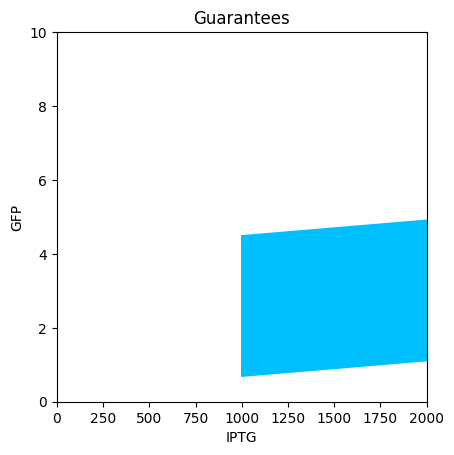

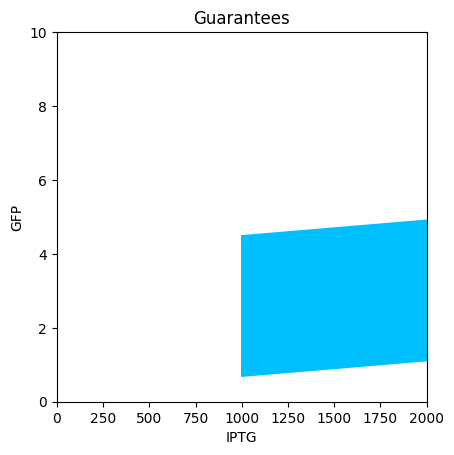

In [19]:
_=plot_guarantees(contract=system_contract_h,
                x_var=system_contract_h.inputvars[0],
                y_var=system_contract_h.outputvars[0],
                var_values={},
                x_lims=(0,2000),
                y_lims=(0,10))

_=plot_guarantees(contract=lux_system_h,
                x_var=lux_system_h.inputvars[0],
                y_var=lux_system_h.outputvars[0],
                var_values={},
                x_lims=(0,2000),
                y_lims=(0,10))

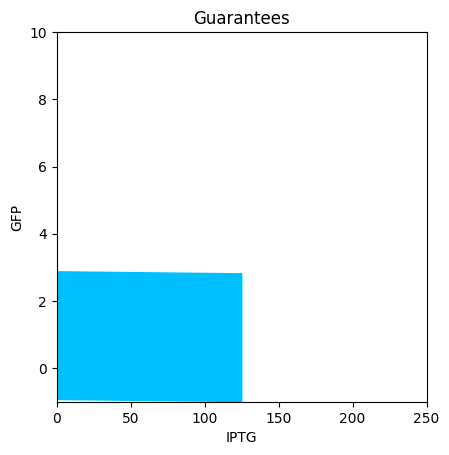

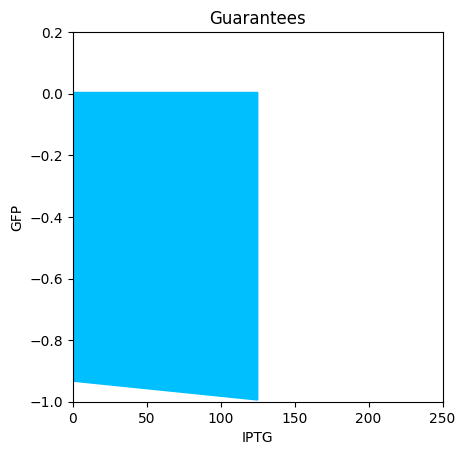

In [23]:
_=plot_guarantees(contract=system_contract_l,
                x_var=system_contract_l.inputvars[0],
                y_var=system_contract_l.outputvars[0],
                var_values={},
                x_lims=(0,250),
                y_lims=(-1,10))

_=plot_guarantees(contract=lux_system_l,
                x_var=lux_system_l.inputvars[0],
                y_var=lux_system_l.outputvars[0],
                var_values={},
                x_lims=(0,250),
                y_lims=(-1,0.2))